# **C23-PR487 ~ LapakIn**

# Background Introduction

Team: C23-PR487
App name: LapakIn


---


Our team aims to simplify the process of starting a MSME by providing a machine learning solution to **classify the most promising location for MSME based on its business type** (i.e. ‘toko kopi’, ‘toko baju’).
This is a **classification problem**, where our machine learning model **learns from dataset of successful MSMEs** which contains success factors as the attributes (i.e. amount of nearest mall, office, and school) and business type as the target label (i.e. ‘toko kopi’, ‘toko baju’).
Then, we use this model to predict the business type of rented business stalls given the above attributes. The **prediction process will result in labels of suitable business type** of the corresponding rented business stall. These labels will then be saved in the database and ready to be fetched in our mobile app. At last, our users can get a list of rented business stalls that suits their desired business type.


---


Dataset of successful MSME is gathered from scraping the Google Maps using Places API for the MSMEs with rating above 4 stars.
Meanwhile, the dataset of available business stalls is gathered from scraping the Google Maps, *rumah.trovit.co.id, lamudi.co.id, olx.co.id*, and *rumah123.com*

# Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

import joblib
from keras.models import load_model
from json import loads, dumps

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/C23PR487/Capstone-Project/main/ML/successful_msme.csv')
df_raw = df_raw[(df_raw['label'] == 'Toko Kopi')|(df_raw['label'] == 'Toko Baju')]
df_raw = df_raw.sample(frac = 1)
classes = 2

# EDA & Preprocessing

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 1595 to 37
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   url                      768 non-null    object 
 1   nama toko                768 non-null    object 
 2   rating                   768 non-null    float64
 3   jumlah review            768 non-null    float64
 4   kategori                 768 non-null    object 
 5   alamat                   768 non-null    object 
 6   kota                     768 non-null    object 
 7   jumlah mall terdekat     768 non-null    int64  
 8   jumlah kantor terdekat   768 non-null    int64  
 9   jumlah sekolah terdekat  768 non-null    int64  
 10  label                    768 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 72.0+ KB


In [4]:
df = df_raw[['jumlah mall terdekat', 'jumlah kantor terdekat', 'jumlah sekolah terdekat', 'label']]

In [5]:
df.head()

,jumlah mall terdekat,jumlah kantor terdekat,jumlah sekolah terdekat,label
1595,2,4,7,Toko Kopi
1470,1,1,6,Toko Baju
1545,6,1,10,Toko Kopi
100,0,0,0,Toko Kopi
589,1,0,0,Toko Kopi


In [6]:
df.describe()

,jumlah mall terdekat,jumlah kantor terdekat,jumlah sekolah terdekat
count,768.000000,768.000000,768.000000
mean,2.359375,2.046875,5.611979
std,2.403499,2.373889,3.556651
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000
50%,2.000000,1.000000,6.000000
75%,3.000000,3.000000,8.000000
max,12.000000,11.000000,16.000000


## Check Duplicate

In [7]:
duplicate_counts = df_raw.duplicated().sum()
print('Amount of duplicate data:')
print(duplicate_counts)

Amount of duplicate data:
0


No duplicates

## Check Null Value

In [8]:
null_counts = df.isnull().sum()
print('Amount of null values on these attributes:')
print(null_counts)

Amount of null values on these attributes:
jumlah mall terdekat       0
jumlah kantor terdekat     0
jumlah sekolah terdekat    0
label                      0
dtype: int64


No null values on our needed attributes (jumlah mall terdekat, jumlah kantor terdekat, jumlah sekolah terdekat, label)

## Check Outlier

In [9]:
def compute_reasonable_bound(selected_attribute):
    Q1 = selected_attribute.quantile(0.25)
    Q3 = selected_attribute.quantile(0.75)
    IQR = Q3-Q1
    return [Q3 + (1.5*IQR), Q1 - (1.5*IQR)]

def compute_outliers(attribute, dataset):
    selected_attribute = dataset.sort_values(by=[attribute])[attribute]
    [RUB, RLB] = compute_reasonable_bound(selected_attribute)
    return len(dataset[(dataset[attribute] > RUB) | (dataset[attribute] < RLB)])

def check_outlier(dataset):
    attributes = []
    outliers = []
    for attribute in df:
        if dataset[attribute].dtype != 'O':
            many_outliers = compute_outliers(attribute, dataset)
            percentage_of_outlier = (many_outliers/len(dataset[attribute])) * 100
            attributes.append(attribute)
            outliers.append(percentage_of_outlier)

    data = {'attribute': attributes, 'percentage of outlier (%)': outliers}
    outlier_df = pd.DataFrame(data)
    return outlier_df

In [10]:
check_outlier(df)

,attribute,percentage of outlier (%)
0,jumlah mall terdekat,7.552083
1,jumlah kantor terdekat,4.296875
2,jumlah sekolah terdekat,0.130208


Outliers are ignored since it's assumed that the percentages as shown above are not significant

## Check Imbalance

In [11]:
print('Total data: ', len(df))

Total data:  768


In [12]:
class_counts = df['label'].value_counts()
print(class_counts)

Toko Kopi    461
Toko Baju    307
Name: label, dtype: int64


Ratio of Toko Kopi : Toko Baju is 1.5 : 1

No further imputation needed on these classes since it's assumed that the ratio as shown above is still pretty balanced

## Encode Label

In [13]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [14]:
labels = [category for category in range(classes)]
labels = list(label_encoder.inverse_transform(labels))
print(labels)

['Toko Baju', 'Toko Kopi']


In [15]:
joblib.dump(label_encoder, 'lapakin_encoder.pkl')

['lapakin_encoder.pkl']

## Split Data

In [16]:
X = df.drop(['label'],axis=1)
y = df['label']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## Normalize

In [18]:
columns = ['jumlah mall terdekat', 'jumlah kantor terdekat', 'jumlah sekolah terdekat']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

In [19]:
joblib.dump(scaler, 'lapakin_scaler.pkl')

['lapakin_scaler.pkl']

# Modeling

In [20]:
class customCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.2):
      print("\nLoss is lower than 0.2, so training is stopped here.")
      self.model.stop_training = True

callbacks = customCallback()

In [36]:
np.random.seed(10)
tf.random.set_seed(10)

In [37]:
model = Sequential(
    [
        Dense(50, activation = 'relu'),
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(classes, activation = 'linear')
    ]
)

# Training

In [38]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    callbacks=[callbacks],
    batch_size = 10,
    epochs=2000
)

Epoch 1/2000
70/70 [==============================] - 1s 2ms/step - loss: 0.6869 - accuracy: 0.5543
Epoch 2/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6749 - accuracy: 0.5861
Epoch 3/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.6064
Epoch 4/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.6035
Epoch 5/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6594 - accuracy: 0.6078
Epoch 6/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6575 - accuracy: 0.6064
Epoch 7/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6564 - accuracy: 0.6035
Epoch 8/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6528 - accuracy: 0.6049
Epoch 9/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6516 - accuracy: 0.6151
Epoch 10/2000
70/70 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6107

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 50)                200       
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 15)                390       
                                                                 
 dense_10 (Dense)            (None, 2)                 32        
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.save('lapakin_model.h5')

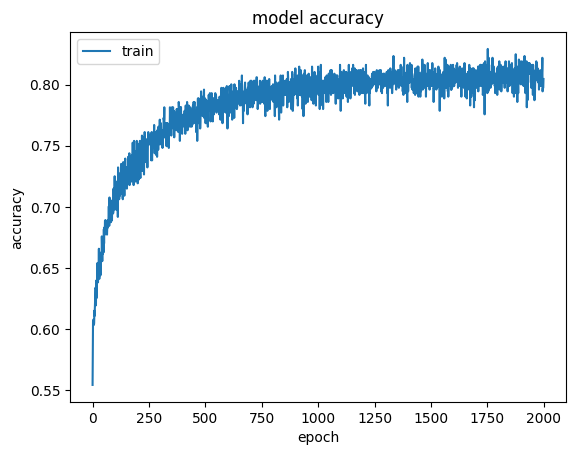

In [41]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

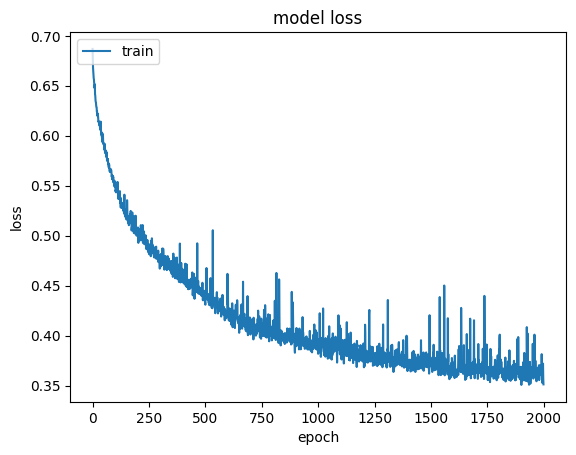

In [42]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Testing

In [43]:
def get_predicted_label(y_result):
  rows = y_result.shape[0]
  y_pred = np.zeros(rows)
  for row in range(rows):
      y_pred[row] = np.argmax(y_result[row])
  return y_pred

In [44]:
def evaluate_classifier_performance(y_prediction, y_test):
    print()

    print('Accuracy:', accuracy_score(y_test, y_prediction)*100, "%")
    print('F1 Macro Average:', f1_score(y_test, y_prediction, average='macro')*100, "%")
    print('F1 Micro Average:', f1_score(y_test, y_prediction, average='micro')*100, "%")
    print('Precision Macro Average:', precision_score(y_test, y_prediction, average='macro')*100, "%")
    print('Precision Micro Average:', precision_score(y_test, y_prediction, average='micro')*100, "%")
    print('Recall Macro Average:', recall_score(y_test, y_prediction, average='macro')*100, "%")
    print('Recall Micro Average:', recall_score(y_test, y_prediction, average='micro')*100, "%")

    print()

    print('Classification Report')
    print(classification_report(y_test, y_prediction))

    print()

    print('Confusion Matrix')
    y_actual = pd.Series(np.array(y_test), name = 'actual')
    y_pred = pd.Series(np.array(y_prediction), name = 'prediction')
    df_confusion = pd.crosstab(y_actual, y_pred)
    display(df_confusion)

## Evaluation

In [45]:
y_prediction = model.predict(X_test)
y_prediction = get_predicted_label(y_prediction).astype(int)
evaluate_classifier_performance(y_prediction, y_test)

3/3 [==============================] - 0s 3ms/step

Accuracy: 71.42857142857143 %
F1 Macro Average: 66.7059748427673 %
F1 Micro Average: 71.42857142857143 %
Precision Macro Average: 66.38461538461539 %
Precision Micro Average: 71.42857142857143 %
Recall Macro Average: 67.14975845410628 %
Recall Micro Average: 71.42857142857143 %

Classification Report
              precision    recall  f1-score   support

           0       0.52      0.57      0.54        23
           1       0.81      0.78      0.79        54

    accuracy                           0.71        77
   macro avg       0.66      0.67      0.67        77
weighted avg       0.72      0.71      0.72        77


Confusion Matrix


prediction,0,1
actual,,
0,13,10
1,12,42


# Predict New Input

In [46]:
def convert_to_json(df):
  result = df.to_json(orient="index")
  parsed = loads(result)
  return dumps(parsed, indent=4)

In [47]:
model = load_model('./lapakin_model.h5')
scaler = joblib.load('lapakin_scaler.pkl')
label_encoder = joblib.load('lapakin_encoder.pkl')

df_stall = pd.read_csv('https://raw.githubusercontent.com/C23PR487/Capstone-Project/main/ML/available_stall.csv', encoding= 'unicode_escape')
X_stall = df_stall[['jumlah mall terdekat', 'jumlah kantor terdekat', 'jumlah sekolah terdekat']]
X_stall= scaler.transform(X_stall)
y_stall = model.predict(X_stall)
df_stall['label'] = label_encoder.inverse_transform(get_predicted_label(y_stall).astype(int))

classified_stalls_json = convert_to_json(df_stall)

2/2 [==============================] - 0s 5ms/step


In [48]:
df_stall.to_csv(r'available_stall_result.csv', index=False, header=True)

In [49]:
classified_stalls_json

'{\n    "0": {\n        "maps": "https://www.google.com/maps/place/MRT+Blok+A/@-6.2557533,106.7952401,18z/data=!4m10!1m2!2m1!1sJl.+Pulo+(Panglima+Polim)+Kebayoran+baru+(MRT+Blok+A)!3m6!1s0x2e69f174f7c27a25:0x8af8a4e5adfcd1ba!8m2!3d-6.2557533!4d106.7971347!15sCjVKbC4gUHVsbyAoUGFuZ2xpbWEgUG9saW0pIEtlYmF5b3JhbiBiYXJ1IChNUlQgQmxvayBBKVoyIjBqbCBwdWxvIHBhbmdsaW1hIHBvbGltIGtlYmF5b3JhbiBiYXJ1IG1ydCBibG9rIGGSAQ5zdWJ3YXlfc3RhdGlvbpoBI0NoWkRTVWhOTUc5blMwVkpRMEZuU1VSbGJsOXRNVXRCRUFF4AEA!16s%2Fg%2F11fx8wlw4_?entry=ttu",\n        "namaLapak": "LAPAK JUALAN STRATEGIS (KAWASAN PERTOKOAN & PERKANTORAN)",\n        "deskripsi": "Disewakan lapak jualan\\n \\n Panglima Polim, Jakarta Selatan\\n \\n STRATEGIS\\n \\n \\u00e2\\u0080\\u00a2 Lokasi 30 meter dari stasiun MRT Blok A\\n \\n \\u00e2\\u0080\\u00a2 Wilayah pertokoan dan perkantoran\\n \\n \\u00e2\\u0080\\u00a2 Ukuran 2 x 4m\\n \\n \\u00e2\\u0080\\u00a2 Disewakan setengah hari (pagi - 16.00 WIB)",\n        "namaPenjual": "Vito",\n        "kontakPenjua

In [50]:
df_stall

,maps,namaLapak,deskripsi,namaPenjual,kontakPenjual,harga,luasBangunan,alamat,kota,kecamatan,urlThumbnail,label,jumlah mall terdekat,jumlah kantor terdekat,jumlah sekolah terdekat,url
0,https://www.google.com/maps/place/MRT+Blok+A/@...,LAPAK JUALAN STRATEGIS (KAWASAN PERTOKOAN & PE...,"Disewakan lapak jualan\n \n Panglima Polim, Ja...",Vito,8.211314e+10,1500000,8 m²,Jl. Pulo (Panglima Polim) Kebayoran baru (MRT ...,Jakarta Selatan,Kebayoran Baru,https://apollo-singapore.akamaized.net/v1/file...,Toko Kopi,3,4,8,https://www.olx.co.id/item/lapak-jualan-strate...
1,https://www.google.com/maps/place/Santa+Modern...,Lapak Usaha Pasar Santa Kebayoran Baru,HARGA SEWA TERMURAH!!!\n \n Pasar Santa sendir...,Arks,8.571666e+10,500000,2 m²,"Pasar Santa, Kebayoran Baru, Jakarta Selatan",Jakarta Selatan,Kebayoran Baru,https://apollo-singapore.akamaized.net/v1/file...,Toko Baju,0,1,4,https://www.olx.co.id/item/lapak-usaha-pasar-s...
2,https://www.google.com/maps/place/South+Jakart...,Ayo Ayooo Siapa Cepat Dia Dapat Langsung Usaha...,Luas tanah 330m2\n \n Luas bangunan 500m2\n \n...,Lianawati Setiawan,8.138500e+10,71000000,500 m²,"Sekitar RT.12/RW.2, Bangka, Mampang Prapatan, ...",Jakarta Selatan,Kebayoran Baru,https://static-id.lamudi.com/static/media/bm9u...,Toko Kopi,9,2,7,https://www.lamudi.co.id/ayo-ayooo-siapa-cepat...
3,https://www.google.com/maps/place/Refill+Parfu...,Disewakan Lapak untuk Gerobak di Pertigaan Str...,Disewakan Lapak untuk Gerobak di Pertigaan Str...,Niyoula,NaN,850000,2 m²,Jl. Sirsak Ujung Pertigaan Jagakarsa 1 Ciganju...,Jakarta Selatan,Jagakarsa,https://apollo-singapore.akamaized.net/v1/file...,Toko Kopi,0,1,8,https://www.olx.co.id/item/disewakan-lapak-unt...
4,https://www.google.com/maps/place/Jl.+Bangun+C...,"Disewa! Rumah cocok u/ usaha di bcs, harga ok",Rumah disewa dengan 1 kamar tidur di Kelapa Ga...,NaN,NaN,18750000,192 m²,Jl. Bangun Cipta Sarana,Jakarta Utara,Kelapa Gading,https://img-ap-1.trovit.com/img1id/1U1Lu1H1RC1...,Toko Kopi,1,3,14,https://rd.clk.thribee.com/id.1U1Lu1H1RC1M1T/o...
5,https://www.google.com/maps/place/Jl.+Teluk+Go...,"Ruang Usaha disewa di Teluk Gong, Jakarta Utar...",Gedung siap pakai usaha apa saja (tidak mau ba...,Tinah Lie,8.777141e+10,33333333,280 m²,"Teluk Gong, Penjaringan, Jakarta Utara",Jakarta Utara,Penjaringan,https://img-ap-1.trovit.com/img1id/1FA1RE1B1CZ...,Toko Kopi,2,3,8,https://rd.clk.thribee.com/id.1FA1RE1B1CZ1Z/or...
6,https://www.google.com/maps/place/The+Mansion+...,"Ruang Usaha disewa di Pademangan, Jakarta Utar...",DISEWAKAN CEPAT OFFICE / RUANG USAHA / GUDANG ...,Metha Aggasi,8.195823e+10,4166666,46 m²,"The Mansion Duku Golf, Pademangan, Jakarta Utara",Jakarta Utara,Pademangan,https://img-ap-1.trovit.com/img1id/1g195gPIY1b...,Toko Kopi,5,3,6,https://rd.clk.thribee.com/id.1g195gPIY1b/orig...
7,https://www.google.com/maps/search/jl.rame+sum...,"Ruang Usaha disewa di Kelapa Gading, Jakarta U...",Kelapagading Jakut Ruang usaha jl.rame Sumagun...,Djie Linda Djauhari Lindapro LINDA,8.128317e+10,8750000,161 m²,"Jl. Rame Sumanggung, Kelapa Gading, Jakarta Utara",Jakarta Utara,Kelapa Gading,https://img-ap-1.trovit.com/img1id/P1H1e-iiE17...,Toko Kopi,1,5,6,https://rd.clk.thribee.com/id.P1H1e-iiE17/orig...
8,https://www.google.com/maps/place/Jl.+Danau+Su...,"Ruang Usaha disewa di Sunter, Jakarta Utara ID...",Rumah blm finishing Danau Sunter Selatan sbrg ...,Djie Linda Djauhari Lindapro LINDA,8.128317e+10,41666666,400 m²,"Danau Sunter, Jakarta Utara",Jakarta Utara,Tanjung Priok,https://img-ap-1.trovit.com/img1id/1K1ecX1sCg0...,Toko Baju,1,0,7,https://rd.clk.thribee.com/id.1K1ecX1sCg0/orig...
9,https://www.google.com/maps/place/TOWER+E/@-6....,"Ruang Usaha disewa di Pluit, Jakarta Utara IDR...",Disewakan Kios Usaha di Apartemen Green Bay ta...,Felix Koemarhadi,8.212226e+10,2916666,15 m²,"Apartemen Green Bay Pluit Tower Edelweiss, Plu...",Jakarta Utara,Penjaringan,https://img-ap-1.trovit.com/img1id/wy1fS1Pu1jR...,Toko Kopi,3,1,1,https://rd.clk.thribee.com/id.wy1fS1Pu1jR/orig...
